In [ ]:
def fix_font():
    # From https://HC.Dle.pw, By Jinseo Kim
    # v1.0.0
    import os
    import matplotlib as mpl
    import matplotlib.pyplot as plt
    os.system("apt-get install -y fonts-nanum")
    os.system("fc-cache -fv")
    mpl.font_manager._rebuild()
    findfont = mpl.font_manager.fontManager.findfont
    mpl.font_manager.findfont = findfont
    mpl.backends.backend_agg.findfont = findfont
    plt.rcParams['font.family'] = "NanumBarunGothic"
    plt.rcParams['axes.unicode_minus'] = False
           
fix_font()

In [ ]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 89.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 23.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 103.4 MB/s eta 0:00:00


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
tokenizer = AutoTokenizer.from_pretrained("beomi/KcELECTRA-base-v2022")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_df = pd.read_csv('/content/drive/MyDrive/sentiment_kcelectra_ver2/emotion_data.csv', encoding = 'cp949')

In [ ]:
train_df = data_df.sample(frac=0.8,random_state=11)
len(train_df)

30875

In [ ]:
test_df = data_df.drop(train_df.index)
len(test_df)

7719

In [ ]:
tokenized_train_sentences = tokenizer(
    list(train_df["text"]),
    return_tensors= "pt",        # pytorch의 tensor 형태로 return
    max_length = 128,            # 최대 토큰 길이
    padding = True,              # 제로패팅
    truncation = True,           # 최대 토큰 길이 초과하면 자름
    add_special_tokens = True,   # special token 추가가
)

In [ ]:
tokenized_test_sentences = tokenizer(
    list(test_df["text"]),
    return_tensors= "pt",        # pytorch의 tensor 형태로 return
    max_length = 128,            # 최대 토큰 길이
    padding = True,              # 제로패팅
    truncation = True,           # 최대 토큰 길이 초과하면 자름
    add_special_tokens = True,   # special token 추가가
)

In [ ]:
class SentimentDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key : torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [ ]:
train_label = train_df["labels"].values
test_label = test_df["labels"].values

train_dataset = SentimentDataset(tokenized_train_sentences, train_label)
test_dataset = SentimentDataset(tokenized_test_sentences, test_label)

In [ ]:
args = TrainingArguments(
    output_dir='/content/drive/MyDrive/sentiment_kcelectra_ver2/',           # 학습결과 저장경로
    num_train_epochs=1,                             # 학습 에포크 설정
    per_device_train_batch_size=64,                 # 학습 배치 사이즈 설정
    per_device_eval_batch_size=64,                  # 테스트 배치 사이즈 설정  
    logging_dir='/content/drive/MyDrive/sentiment_kcelectra_ver2/logs',      # 학습 log 저장 경로
    logging_steps=500,                              # 학습 log 기록 단위
    save_total_limit=2,                              # 학습 결과 저장 최대 갯수
    resume_from_checkpoint=True
)   

In [ ]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

In [ ]:
# 평가지표를 위한 함수
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds)
    acc = accuracy_score(labels, preds)
    return {
        'accuracy' : acc,
        'f1' : f1,
        'precision' : precision,
        'recall' : recall
    }

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained("/content/drive/MyDrive/sentiment_kcelectra_ver2/checkpoint-2000")
model.to(device)

loading configuration file /content/drive/MyDrive/sentiment_kceletra_ver2/checkpoint-2000/config.json
Model config ElectraConfig {
  "_name_or_path": "/content/drive/MyDrive/sentiment_kceletra_ver2/checkpoint-2000",
  "architectures": [
    "ElectraForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "embedding_size": 768,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5,
    "LABEL_6": 6
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "electra",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embeddin

ElectraForSequenceClassification(
  (electra): ElectraModel(
    (embeddings): ElectraEmbeddings(
      (word_embeddings): Embedding(54343, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): ElectraEncoder(
      (layer): ModuleList(
        (0): ElectraLayer(
          (attention): ElectraAttention(
            (self): ElectraSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): ElectraSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm

In [ ]:
trainer = Trainer(
    model = model,
    args = args,
    train_dataset = train_dataset,
    eval_dataset = test_dataset,
    compute_metrics=compute_metrics,
)

In [ ]:
trainer.evaluate(eval_dataset=test_dataset)

***** Running Evaluation *****
  Num examples = 7719
  Batch size = 64
<ipython-input-10-8f22ac0f3218>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key : torch.tensor(val[idx]) for key, val in self.encodings.items()}


Trainer is attempting to log a value of "[0.67454545 0.42300988 0.81846393 0.46680942 0.52716108 0.62748907
 0.58649094]" of type <class 'numpy.ndarray'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.65202109 0.47957839 0.77516532 0.42711599 0.55522388 0.69090909
 0.57188755]" of type <class 'numpy.ndarray'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.69868173 0.37837838 0.86688578 0.51463645 0.50179856 0.5747331
 0.60185968]" of type <class 'numpy.ndarray'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


{'eval_loss': 1.2360644340515137,
 'eval_accuracy': 0.5987822256769012,
 'eval_f1': array([0.67454545, 0.42300988, 0.81846393, 0.46680942, 0.52716108,
        0.62748907, 0.58649094]),
 'eval_precision': array([0.65202109, 0.47957839, 0.77516532, 0.42711599, 0.55522388,
        0.69090909, 0.57188755]),
 'eval_recall': array([0.69868173, 0.37837838, 0.86688578, 0.51463645, 0.50179856,
        0.5747331 , 0.60185968]),
 'eval_runtime': 51.298,
 'eval_samples_per_second': 150.474,
 'eval_steps_per_second': 2.359}

문장을 입력해주세요: 왜 그러는데


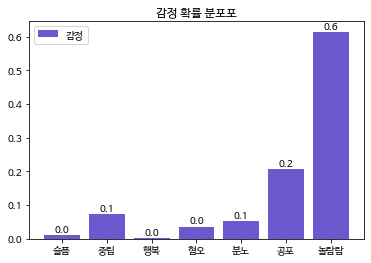

tensor([[0.0120, 0.0737, 0.0032, 0.0362, 0.0524, 0.2076, 0.6149]])
놀람


문장을 입력해주세요: 시발


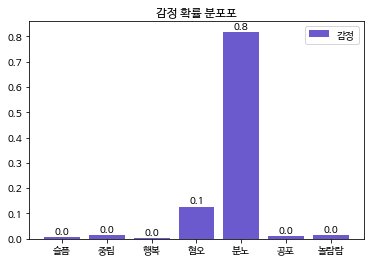

tensor([[0.0078, 0.0152, 0.0044, 0.1276, 0.8178, 0.0112, 0.0160]])
분노


문장을 입력해주세요: 집에 가고 싶어ㅜㅜ


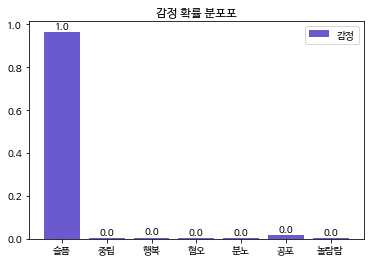

tensor([[0.9663, 0.0037, 0.0053, 0.0034, 0.0035, 0.0157, 0.0021]])
슬픔


문장을 입력해주세요: 도망가자 제발


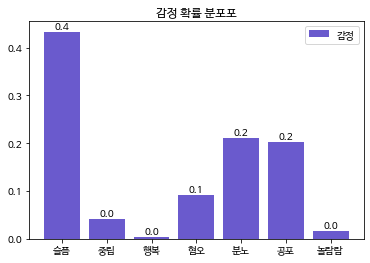

tensor([[0.4335, 0.0414, 0.0041, 0.0918, 0.2114, 0.2020, 0.0158]])
슬픔


문장을 입력해주세요: 역겨워 진짜


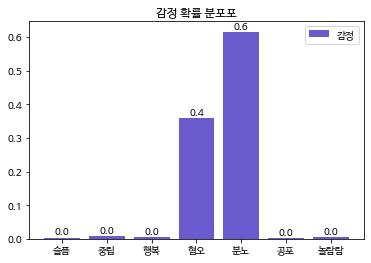

tensor([[0.0038, 0.0088, 0.0043, 0.3597, 0.6157, 0.0024, 0.0053]])
분노




KeyboardInterrupt: ignored

In [ ]:
def sentence_predict(sent):
    # 평가모드로 변경
    model.eval()

    # 입력된 문장 토크나이징
    tokenized_sent = tokenizer(
        sent,
        return_tensors="pt",
        truncation=True,
        add_special_tokens=True,
        max_length=128
    )

    # 모델이 위치한 GPU로 이동
    tokenized_sent.to(device)

    # 예측
    with torch.no_grad():
        outputs = model(
            input_ids = tokenized_sent["input_ids"],
            attention_mask=tokenized_sent["attention_mask"],
            token_type_ids=tokenized_sent["token_type_ids"]
        )

    # 결과 return
    logits = outputs[0]
    logits = logits.detach().cpu()
    prob = logits.softmax(dim=1)
    x = ['슬픔', '중립', '행복', '혐오', '분노', '공포', '놀람']
    y = [prob[0][0], prob[0][1], prob[0][2],prob[0][3],prob[0][4],prob[0][5], prob[0][6]]

    bar = plt.bar(x,y,color='slateblue')
    for rect in bar:
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width()/2.0, height, '%.1f' % height, ha='center', va='bottom', size = 10)
    plt.title('감정 확률 분포포')
    plt.legend(['감정'])
    plt.show()

    print(prob)
    result = logits.argmax(-1)
    if result == 0:
        result = "슬픔"
    elif result == 1:
        result = "중립"
    elif result == 2:
        result = "행복"
    elif result == 3: 
        result = "혐오"
    elif result == 4:
        result = "분노"
    elif result == 5:
        result = "공포"
    elif result == 6:
        result = "놀람"
    return result

#0 입력시 종료
while True:
     sentence = input("문장을 입력해주세요: ")
     if sentence == "0": 
         break
     print(sentence_predict(sentence))
     print("\n")
    

In [ ]:
import matplotlib.pyplot as plt

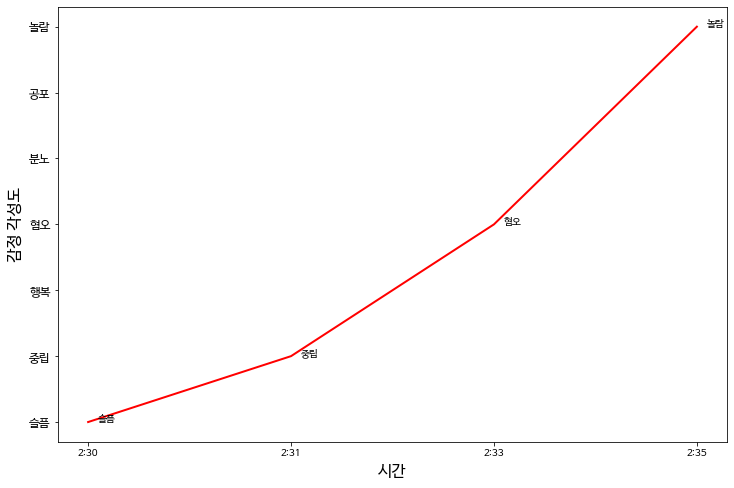

In [ ]:
time_list = ['2:30', '2:31', '2:33', '2:35']
emo_list = [0,1,3,6]
emo_label = ['슬픔', '중립', '행복', '혐오', '분노', '공포', '놀람']

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(1, 1, 1)

ax.plot(time_list, emo_list, color='red', linewidth=2)

ax.set_yticks([0, 1, 2, 3, 4, 5, 6])
ax.set_yticklabels(emo_label, fontsize=12)
for i in range(len(emo_list)):
    ax.text(0.05 + i,emo_list[i],emo_label[emo_list[i]])
ax.set_xlabel('시간', fontsize=16)
ax.set_ylabel('감정 각성도', fontsize=16)

plt.show()

In [ ]:
from datetime import date, datetime, timezone, timedelta

KST = timezone(timedelta(hours=9))
time_record = datetime.now(KST)
_time = str(time_record.time())[:8]
print(_time)

16:02:10
